In [2]:
import numpy as np
import pandas as pd 
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') 

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader


from sklearn.model_selection import RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import metrics 
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


data = pd.read_csv('UCI_Credit_Card.csv', delimiter = ',') # reading the data form csv file
data_rec = pd.DataFrame() #dataframe to store the recreated data

column: 1


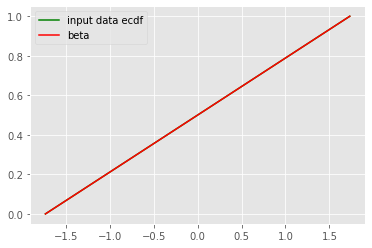

column: 2


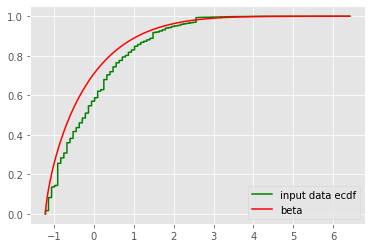

column: 3


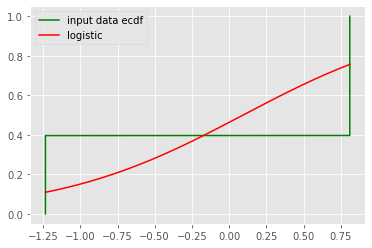

column: 4


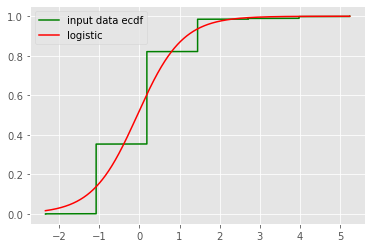

column: 5


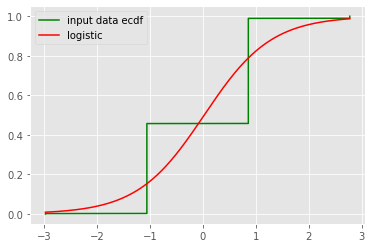

column: 6


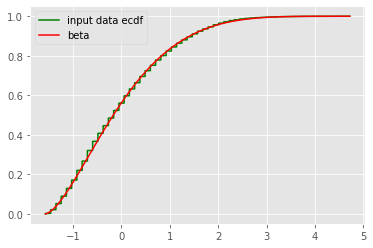

column: 7


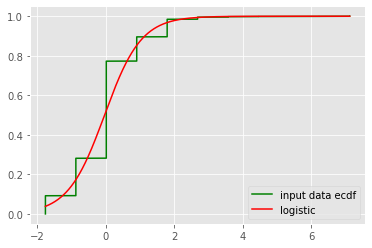

column: 8


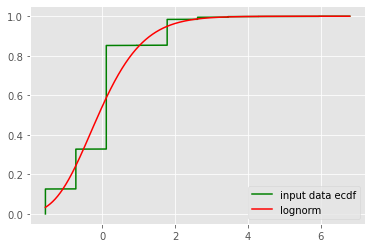

column: 9


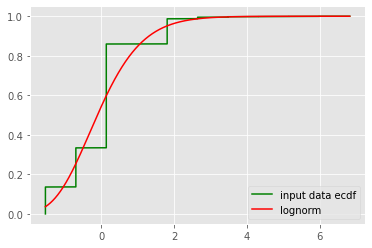

column: 10


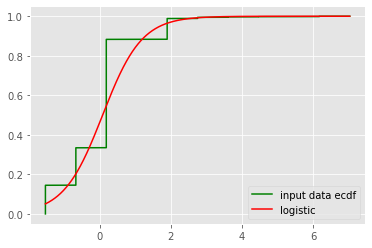

column: 11


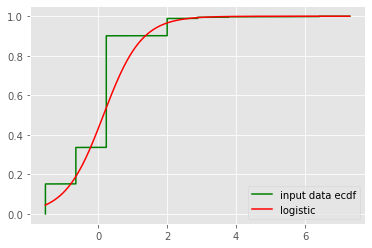

column: 12


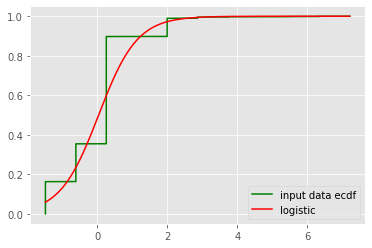

column: 13


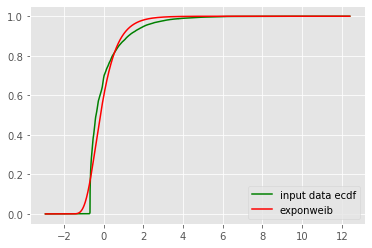

column: 14


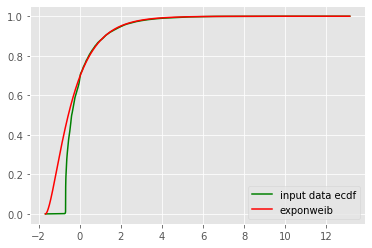

column: 15


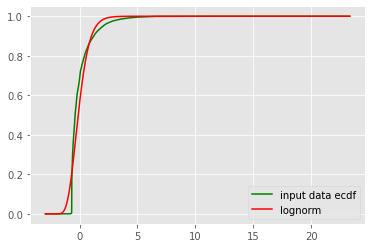

column: 16


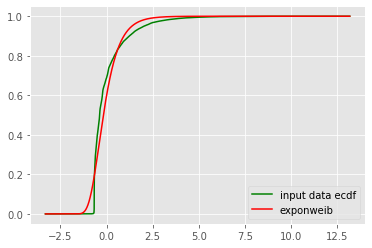

column: 17


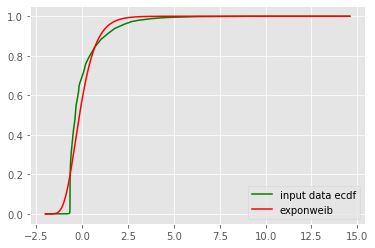

column: 18


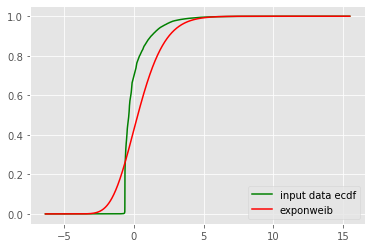

column: 19


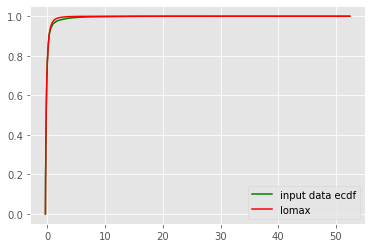

column: 20


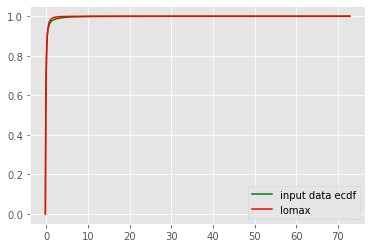

column: 21


In [ ]:

max_dist = [''] * len(data.columns) #to save the maximum distribution present in each feature



dist_names = ['norm',
              'exponweib',
              'chi2',
              'lognorm',
              'beta',
              'cauchy',
              'cosine',
              'gamma',
              'logistic',
              'lomax',
              'maxwell',
              'rdist',
              'uniform', 
              'erlang']

for i in range(0,len(data.columns)):
        print("column:", i+1)
        #standardization
        s_data = data[data.columns[i]]
        scaled = ((s_data-s_data.mean())/s_data.std())
        y_std= scaled 
        emperical = [(1 + k) / len(y_std) for k in range(len(y_std))] # to plot ecdf
        t = np.linspace(min(y_std), max(y_std),30000)

        # breaking the data in batches of 100
        data_batch = DataLoader(data[data.columns[i]], batch_size=100, shuffle = True)
        p_val = [0] * len(data_batch)
        q_val = [''] * len(data_batch)
        D_val = [0] * len(data_batch)
        
        #Matching distribution
        j=0;
        for dat in data_batch: 
            dt = dat.numpy()
            dt = (dt - dt.mean())/dt.std()
            for distribution in dist_names:
                dist = getattr(stats, distribution)
                param = dist.fit(dt)
                d,p = stats.kstest(dt, distribution, args=param)
                if p_val[j]<p:
                    p_val[j] = p
                    D_val[j] = d
                    q_val[j] = distribution
            j= j+1
        #recreating the distribution from the most accuring distribution and fitting its parameters
        max_dist[i] = stats.mode(q_val)[0][0] # mode to find the maximun occuring distribution
        param1 = getattr(stats,max_dist[i] ).fit(y_std) 
        plt.plot(np.sort(y_std),emperical, color = 'g', label = 'input data ecdf')
        plt.plot(t,getattr(scipy.stats,max_dist[i] ).cdf(t,*param1[:-2], loc=param1[-2], scale=param1[-1]), color = 'r', label = max_dist[i])
        plt.legend()
        plt.show()
        data_rec[data.columns[i]] = getattr(scipy.stats, max_dist[i]).rvs(*param1[:-2], loc=param1[-2], scale=param1[-1], size = 30000)

In [3]:
max_dist

['beta',
 'beta',
 'logistic',
 'logistic',
 'logistic',
 'beta',
 'logistic',
 'lognorm',
 'lognorm',
 'logistic',
 'logistic',
 'logistic',
 'exponweib',
 'exponweib',
 'exponweib',
 'exponweib',
 'exponweib',
 'lognorm',
 'lomax',
 'lomax',
 'lomax',
 'lomax',
 'lomax',
 'lomax',
 'logistic']

In [4]:
data_rec.rename(columns={"default.payment.next.month": "Default"}, inplace=True)
data.rename(columns={"default.payment.next.month": "Default"}, inplace=True)
data.drop('ID', axis = 1, inplace =True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [5]:
y = data.Default     # target default=1 or non-default=0
features = data.drop('Default', axis = 1, inplace = False)
#data processing step to remove the non unique data points and chnage them with unique data
data['EDUCATION']=np.where(data['EDUCATION'] == 5, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 6, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 0, 4, data['EDUCATION'])
data['MARRIAGE']=np.where(data['MARRIAGE'] == 0, 3, data['MARRIAGE'])
data['MARRIAGE'].unique()


In [ ]:
# Original data
X = data.drop('Default', axis=1)  
y = data['Default']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42) # test train spiliting

#searching for best paramneters for random forest
param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

In [ ]:
Ran = RandomForestClassifier(criterion= 'gini', oob_score = True,max_depth= 5, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)
Ran.fit(X_train, y_train) #rf classifier training
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

In [34]:
#label points changing
data_t = data.loc[data["Default"] == 0]
data_f = data.loc[data["Default"] == 1]
data_t1 = data_t[:2*len(data_f)]
data_new=pd.concat([data_t1, data_f])

In [35]:
data_new["Default"].value_counts()

0    13272
1     6636
Name: Default, dtype: int64

In [36]:
data_new

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,50000.0,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,500000.0,1,1,2,29,0,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991,210000.0,1,2,1,34,3,2,2,2,2,...,2500.0,2500.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,1
29994,80000.0,1,2,2,34,2,2,2,2,2,...,77519.0,82607.0,81158.0,7000.0,3500.0,0.0,7000.0,0.0,4000.0,1
29997,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [47]:
# 
X = data_new.drop('Default', axis=1)  
y = data_new['Default']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)


param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 150, 'max_features': 5, 'max_depth': 6, 'criterion': 'gini'}


Accuracy: 0.8168333333333333

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000


Average 5-Fold CV Score: 0.8199 , Standard deviation: 0.0095


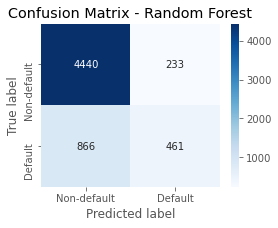

In [48]:
Ran = RandomForestClassifier(criterion= 'gini', oob_score = True,max_depth= 5, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest")

In [39]:
data_rec.drop('ID', axis = 1, inplace =True)
#predicting labels to the recreated synthetic data
X_t = data_rec.drop('Default', axis=1)
y_pred = Ran.predict(X_t)
data_rec['Default'] = y_pred 

In [1]:
data_rec["Default"].value_counts()

NameError: name 'data_rec' is not defined

In [41]:
data_rec

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,-1.099104,-1.000353,-2.030837,1.050125,-0.480044,0.613751,-0.532716,-0.766318,-0.228148,0.526325,...,0.171832,0.170250,0.545675,-0.155293,-0.243818,-0.289584,0.160330,-0.243367,-0.275687,0
1,-1.197348,-1.230603,1.432577,3.757707,-0.449573,1.087044,0.159346,-1.150588,-1.664705,-0.136778,...,-0.250853,-0.864256,-0.989283,-0.202532,0.181031,-0.252158,0.355668,-0.184866,-0.252574,0
2,-1.076845,-0.088585,-1.735467,-1.495139,-0.934324,-0.751516,-1.022818,1.156737,0.917974,-0.681296,...,0.838344,0.235425,-0.480243,-0.122200,-0.204900,0.008779,-0.053633,0.303360,-0.195223,0
3,2.653101,-0.884788,0.197236,1.106280,-0.845796,-0.295310,0.333339,-0.054073,-0.533751,-0.319580,...,0.628089,0.767907,0.413122,-0.171795,-0.213449,-0.291948,-0.303314,0.107616,-0.262997,0
4,-0.154980,-0.015561,-1.682850,-0.593923,0.917448,-0.915439,-0.642881,0.450813,0.221588,-1.358693,...,0.745106,-0.513656,0.072612,0.162087,-0.252654,-0.162864,-0.084476,-0.160213,-0.177008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.115760,-0.315433,1.346217,2.699792,0.257311,0.549478,-0.176283,-2.201322,0.252612,-0.275743,...,-0.261626,0.686763,0.448513,0.060608,-0.221664,0.344941,-0.240970,-0.313707,-0.218728,0
29996,1.228597,2.153592,-0.306556,0.372846,1.993125,0.091545,-0.587709,0.109802,0.359488,-0.716577,...,0.442815,0.083324,-0.445214,0.017267,-0.245578,0.137506,-0.134162,0.010502,-0.228813,0
29997,-0.951455,-0.529170,0.689030,-0.350077,-1.567360,-1.520746,-0.004077,-0.054652,-0.848283,1.289207,...,-0.042197,0.693177,-0.448965,-0.303431,-0.106578,-0.278572,-0.116316,-0.234927,-0.223765,0
29998,-0.073980,-0.121465,-0.898173,1.088123,0.560147,0.365460,0.738578,-0.942222,0.675052,-0.250193,...,0.351964,-0.053508,-1.502024,-0.303820,-0.235178,-0.286552,-0.223669,-0.285965,-0.223148,0


In [42]:

#training model on the racreated data with predicted labels
X = data_rec.drop('Default', axis=1)  
y = data_rec['Default']


param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 150, 'max_features': 5, 'max_depth': 6, 'criterion': 'gini'}


In [ ]:
Ran = RandomForestClassifier(criterion= 'gini', oob_score = True,max_depth= 5, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)
Ran.fit(X, y)

Accuracy: 0.8041666666666667

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4673
           1       0.57      0.49      0.52      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.69      0.70      6000
weighted avg       0.80      0.80      0.80      6000


Average 5-Fold CV Score: 0.821 , Standard deviation: 0.01


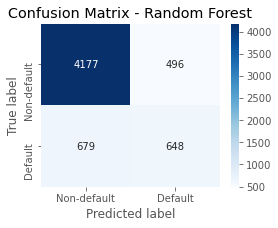

In [46]:
#testing new trained model on original test set
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))
## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

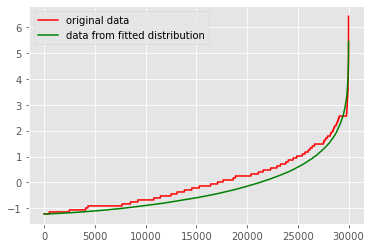

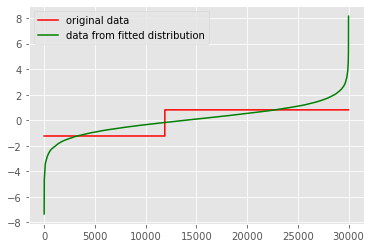

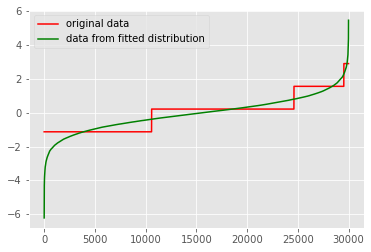

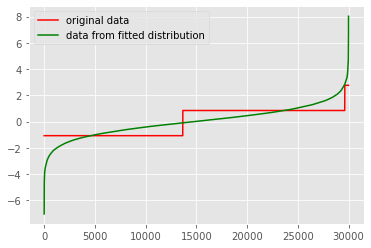

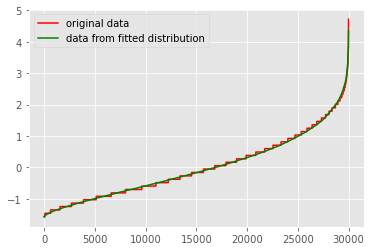

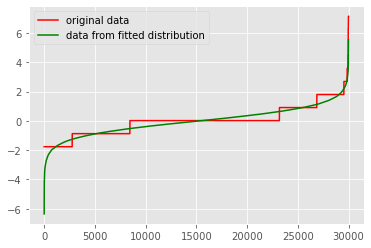

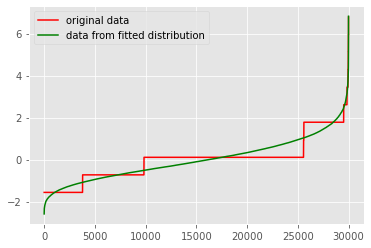

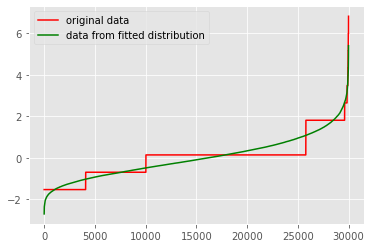

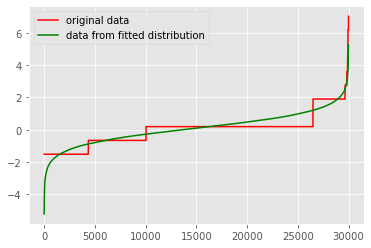

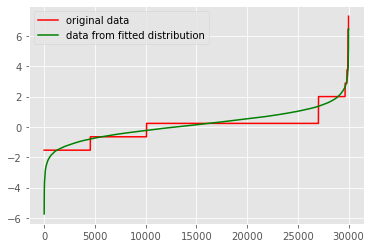

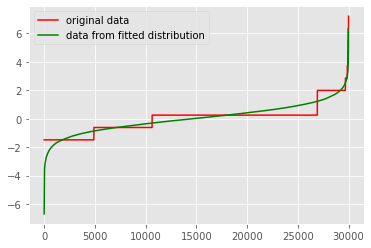

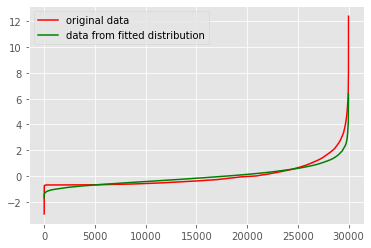

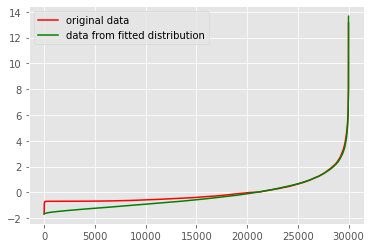

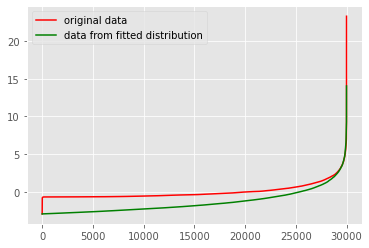

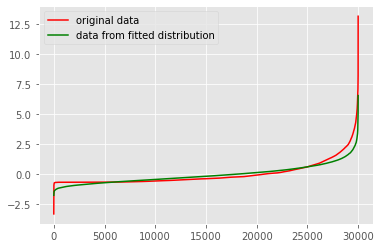

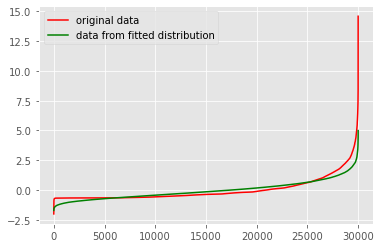

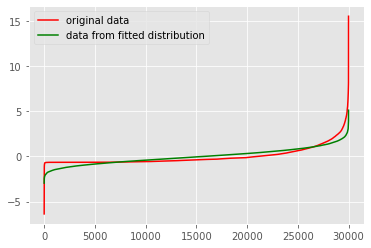

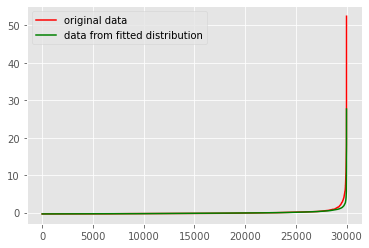

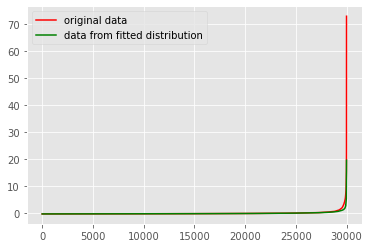

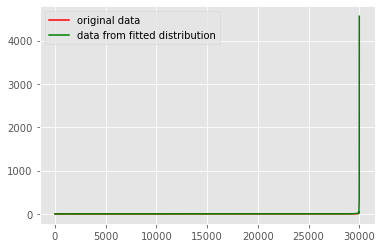

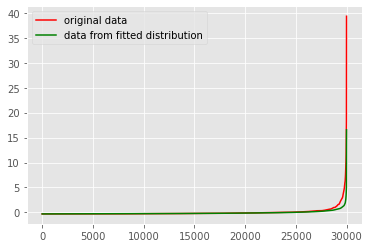

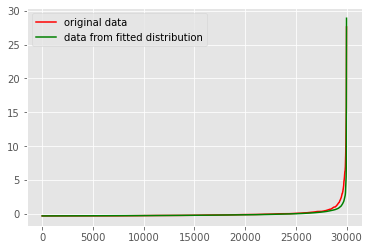

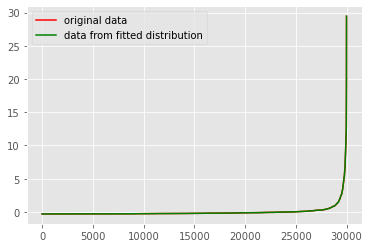

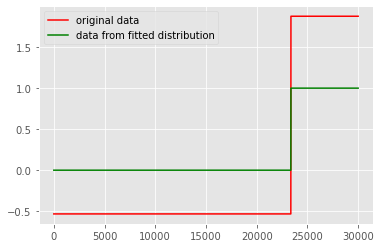

In [25]:
#plots
for column in data:
    sorted_data = np.sort(data[column])
    scaled = ((sorted_data-sorted_data.mean())/sorted_data.std())
    plt.plot(scaled, color = 'r', label = 'original data')
    plt.plot(np.sort(data_rec[column]), color = 'g', label = 'data from fitted distribution')
    plt.legend()
    plt.show()